In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import subprocess
import sys
sys.path.append('../..')

import pickle
import numpy as np
import matplotlib.pyplot as plt

from IRSMicroLensing import IRSCaustics as IRSC
from IRSMicroLensing import IRSFunctions as IRSF

import VBMicrolensing
from skimage.draw import line

#### Initializing VBMicrolensing

In [2]:
VBM = VBMicrolensing.VBMicrolensing()

# Set relative accuracy
VBM.RelTol = 1e-03

# Set accuracy
VBM.Tol=1e-03

#### Defining reader function to read in IRSCaustic objects from file

In [3]:
def caustic_reader(file_path: str) -> IRSC.IRSCaustics:
    with open(file_path, 'rb') as f:
        return pickle.load(f)

#### Reading in single lens and triple lens objects

In [5]:
single_lens = caustic_reader('../Simulations/single_lens_1e11.pkl')
triple_lens = caustic_reader('../Simulations/triple_lens_1e11.pkl')

ang_width = single_lens.ang_width
pixels = single_lens.pixels
ang_res = single_lens.ang_res

print(f'Number of rays: {single_lens.num_rays:.4e}')
print(f'Number of rays: {triple_lens.num_rays:.4e}')

Number of rays: 1.5192e+11
Number of rays: 1.5192e+11


#### Viewing magnification maps

Plotting magnification map: 0.076 seconds
Plotting magnification map: 0.017 seconds


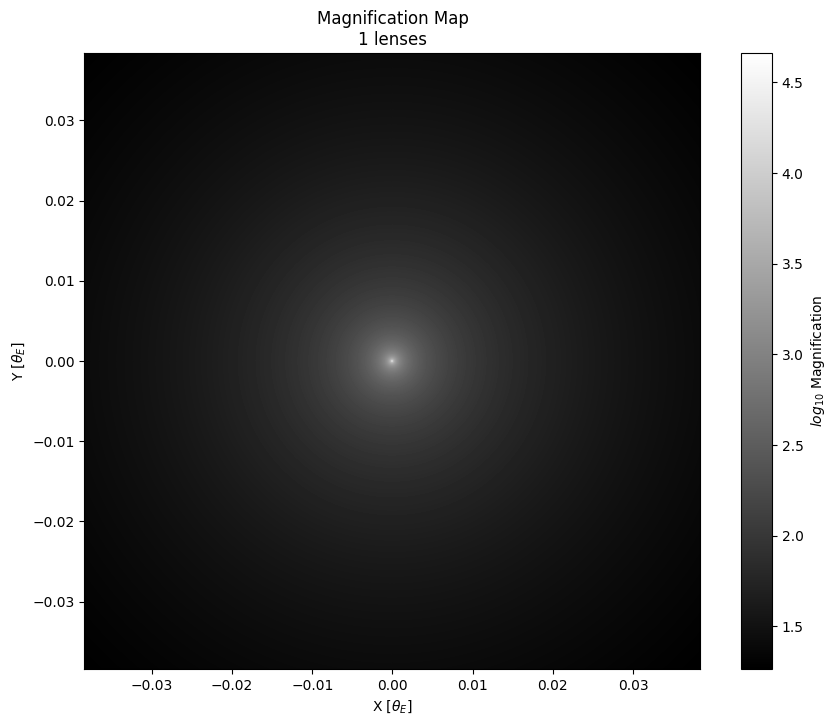

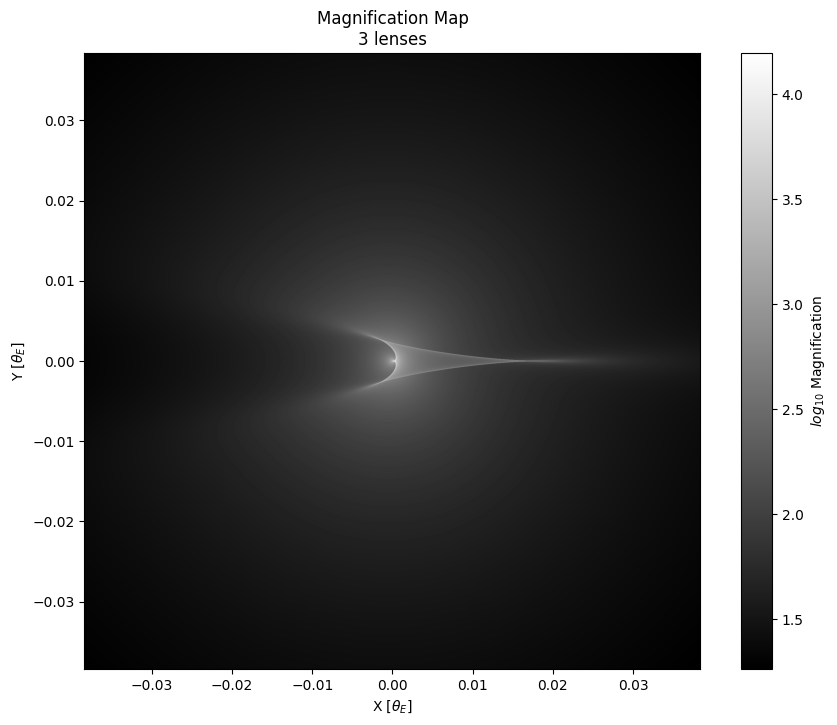

In [6]:
single_lens.plot()
triple_lens.plot()

plt.show()

#### Defining source profile

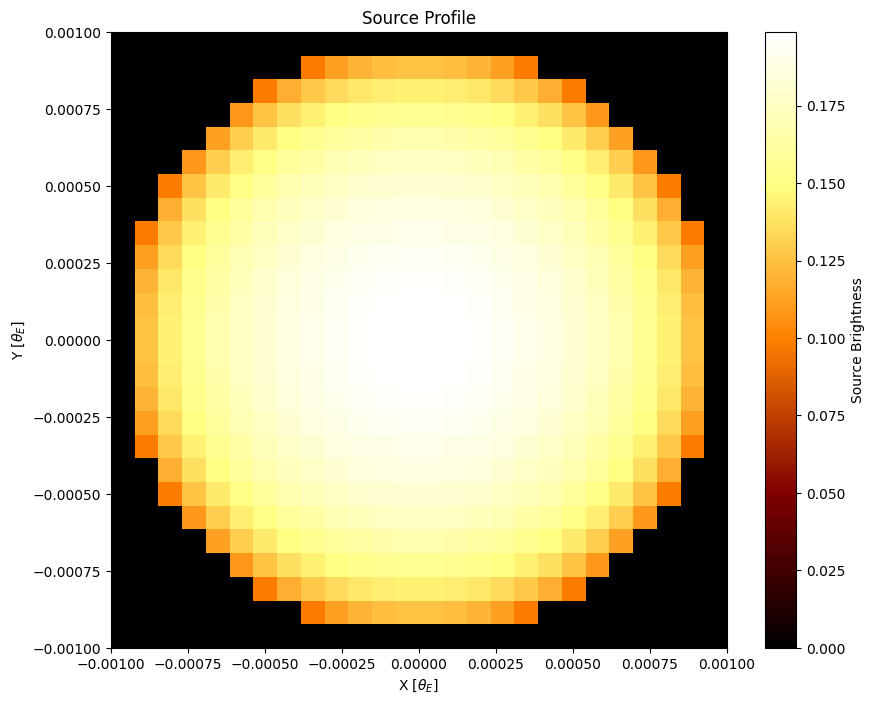

In [7]:
radius = 1e-3
LD = 0.5

source_profile = IRSF.IRSFunctions.source_profile(ang_res=single_lens.param_dict['ang_res'], rad=radius, profile_type='LD', LD=LD)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

img = ax.imshow(source_profile, cmap='afmhot', extent=[-radius, radius, -radius, radius])
plt.colorbar(img, ax=ax, label='Source Brightness')

ax.set_xlabel('X [$\\theta_E$]')
ax.set_ylabel('Y [$\\theta_E$]')
ax.set_title('Source Profile')

ax.set_aspect('equal')

#### Convolving source profile with both single lens and triple lens magnification maps

Convolving source profile with magnification map: 0.183 seconds
Convolving source profile with magnification map: 0.105 seconds


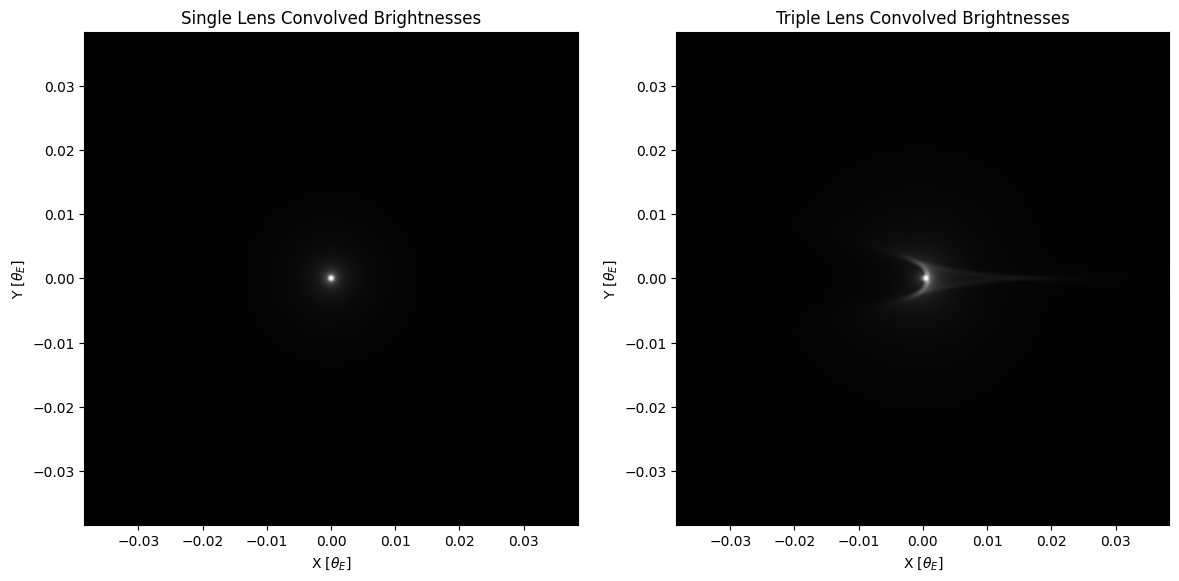

In [8]:
convolved_single_lens = single_lens.convolve(source_profile=source_profile)
convolved_triple_lens = triple_lens.convolve(source_profile=source_profile)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(convolved_single_lens, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])
ax2.imshow(convolved_triple_lens, cmap='gray', extent=[-single_lens.ang_width/2, single_lens.ang_width/2, -single_lens.ang_width/2, single_lens.ang_width/2])

ax1.set_xlabel('X [$\\theta_E$]')
ax1.set_ylabel('Y [$\\theta_E$]')
ax1.set_title('Single Lens Convolved Brightnesses')
ax1.set_aspect('equal')

ax2.set_xlabel('X [$\\theta_E$]')
ax2.set_ylabel('Y [$\\theta_E$]')
ax2.set_title('Triple Lens Convolved Brightnesses')
ax2.set_aspect('equal')

plt.show()

#### Function to find all caustic points

In [9]:
def find_cusp_points(caustic_points):
    points = caustic_points.T  # Shape: (400, 2)

    vectors = np.diff(points, axis=0)  # Shape: (399, 2)

    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    unit_vectors = vectors / norms

    dot_products = np.sum(unit_vectors[:-1] * unit_vectors[1:], axis=1)
    dot_products = np.clip(dot_products, -1.0, 1.0)  # Clip to avoid numerical errors
    angles = np.rad2deg(np.arccos(dot_products))  # In degrees

    cusp_indices = np.where(angles > 50)[0] + 1  # +1 to shift to the index of the corner point

    return caustic_points[0, cusp_indices], caustic_points[1, cusp_indices]

#### Calculating and Plotting VBMicrolensing caustics

0.0002470252450260668 1.3212232075066055e-07


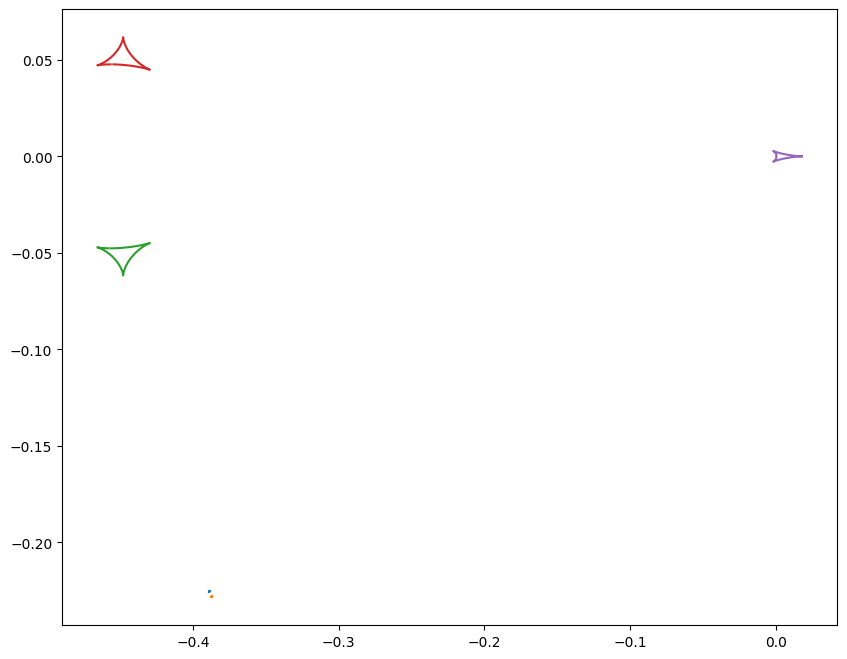

In [10]:
parameters = [item for sublist in triple_lens.lens_att for idx, item in enumerate(sublist) if idx != 2]
VBM.SetLensGeometry(parameters)

caustic_points = VBM.Multicaustics()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

all_cusp_xs = []
all_cusp_ys = []

for points in caustic_points:
    ax.plot(points[0], points[1])
    xs, ys = find_cusp_points(np.array(points))
    all_cusp_xs.append(xs)
    all_cusp_ys.append(ys)

all_cusp_xs = np.array(all_cusp_xs)
all_cusp_ys = np.array(all_cusp_ys)

all_cusp_distances = np.sqrt(all_cusp_xs**2 + all_cusp_ys**2)
min_indices = np.unravel_index(np.argmin(all_cusp_distances), all_cusp_distances.shape)

print(all_cusp_xs[min_indices], all_cusp_ys[min_indices])

plt.show()

#### Plotting deviation contours

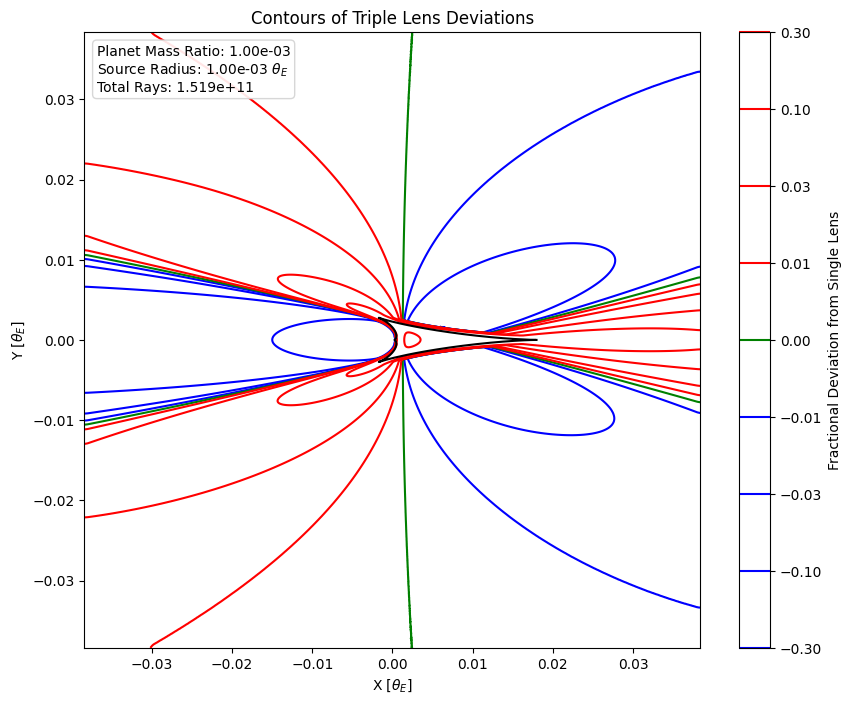

In [11]:
fractional_deviations = (convolved_triple_lens - convolved_single_lens) / convolved_single_lens

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

# img = ax.imshow(fractional_deviations, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2], cmap='grey')

img = plt.contour(single_lens.X_pix, single_lens.Y_pix, fractional_deviations,
                   levels=[-0.30, -0.10, -0.03, -0.01, 0, 0.01, 0.03, 0.10, 0.30],
                   colors=['blue', 'blue', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red']
)

bar = plt.colorbar(img)
bar.set_label('Fractional Deviation from Single Lens')

ax.plot(caustic_points[min_indices[0]][0], caustic_points[min_indices[0]][1], color='black')

ax.set_title(f'Contours of Triple Lens Deviations')
ax.set_aspect('equal')
ax.set_xlim(-ang_width/2, ang_width/2)
ax.set_ylim(-ang_width/2, ang_width/2)

props = dict(boxstyle='round', facecolor='white', edgecolor='lightgray', alpha=0.9)
ax.text(0.02, 0.98, f'Planet Mass Ratio: {(triple_lens.lens_att[2][3] / triple_lens.lens_att[1][3]):.2e}\nSource Radius: {radius:.2e} $\\theta_E$\nTotal Rays: {(single_lens.num_rays):.3e}', va='top', zorder=10, bbox=props, transform=ax.transAxes, color='black')

ax.set_xlabel('X [$\\theta_E$]')
ax.set_ylabel('Y [$\\theta_E$]')

fig.savefig('Contours_Accurate.png', dpi=500)

plt.show()

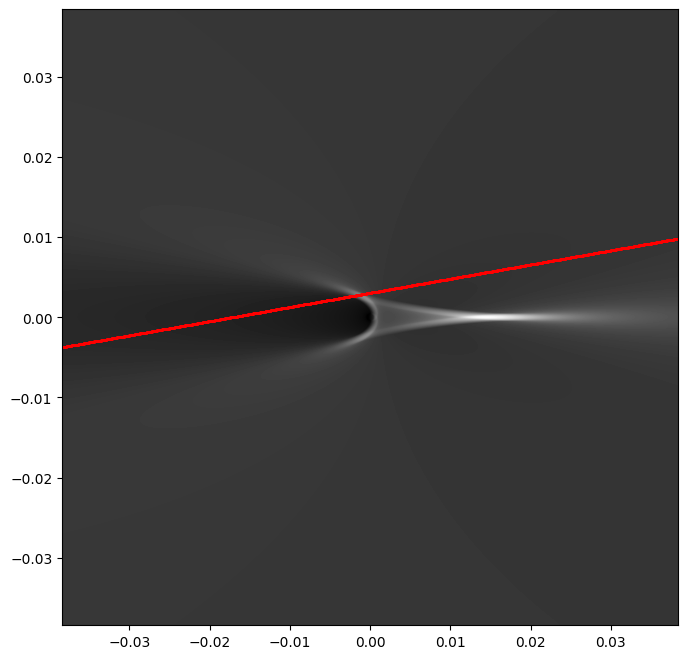

In [13]:
# Impact parameter
u = 0.003

# Angle from x axis
alpha = 10

intersections, (xs, ys), times, vals = IRSC.IRSCaustics.lightcurve_calculator(u, alpha, ang_width, fractional_deviations)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.imshow(fractional_deviations, extent=[-ang_width/2, ang_width/2, -ang_width/2, ang_width/2], cmap='gray')
ax.scatter(xs, ys, s=1, color='red')

plt.show()

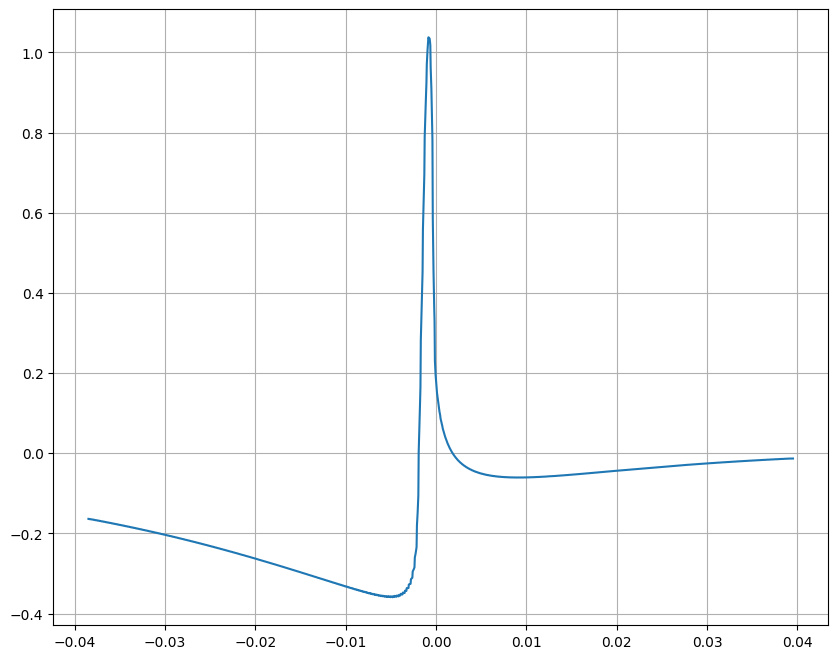

In [16]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()

ax.plot(times, vals)

ax.grid(True)

plt.show()